In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# **Data understanding**
Este dataset se compone de 219 instancias y 13 variables:
* age: edad del paciente (en años)
* anemia: Baja en el conteo de globulos rojos en la sangre (boleano)
* creatinine_phosphokinase: Niveles de la enzima CPK en la sangre (mcg/L)
* diabetes: Si el paciente tiene diabetes (boleano)
* ejection_fraction: Porcentaje de sangre que abandona el corazón con cada contración (porcentaje).
* high_blood_pressure: Si el paciente tiene hipertensión (boleano)
* platelets: Niveles de platelets en la sangre (kiloplatelets/mL)
* serum_creatinine: Niveles de serum creatinine en la sangre (mg/dL)
* serum_sodium: Niveles de sodio en la sangre (mEq/L)
* sex: Si el paciente es hombre o mujer (binario)
* smoking: Si el paciente fuma o no (boleano)
* time: Tiempo de seguimiento (días)
* DEATH_EVENT: Si el paciente fallecio durante el periodo de seguimiento

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/heart_failure_clinical_records_dataset.csv')

In [ ]:
# Primer vistazo al df
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
# Visualizamos cómo está guardada la información
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

Aún cuando (por el contexto del problema) todas las columnas deberían contener información numérica, nos dimos cuenta de que la edad está guardada como si fuera un flotante... cosa que no hace mucho sentido, sin embargo, visualizamos cómo está guardada la información antes de realizar cualquier cambio. 

In [ ]:
# Valores únicos en la columna age
df.age.unique()

array([75.   , 55.   , 65.   , 50.   , 90.   , 60.   , 80.   , 62.   ,
       45.   , 49.   , 82.   , 87.   , 70.   , 48.   , 68.   , 53.   ,
       95.   , 58.   , 94.   , 85.   , 69.   , 72.   , 51.   , 57.   ,
       42.   , 41.   , 67.   , 79.   , 59.   , 44.   , 63.   , 86.   ,
       66.   , 43.   , 46.   , 61.   , 81.   , 52.   , 64.   , 40.   ,
       60.667, 73.   , 77.   , 78.   , 54.   , 47.   , 56.   ])

Notamos que hay mínimo un dato mal guardado. Visualizamos si se trata de un caso aislado o si es algo que debamos de tomar en consideración

In [ ]:
df[df.age==60.667]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
185,60.667,1,104,1,30,0,389000.0,1.5,136,1,0,171,1
188,60.667,1,151,1,40,1,201000.0,1.0,136,0,0,172,0


Solamente son dos valores... realmente no son relevantes ante esta tarea y de hecho están perjudicando mi dataset. Procedo a liminarlos

In [ ]:
# Filtramos los datos 
df = df[df.age!=60.667]
# Cambiamos el tipo de dato de la columna edad
df.age = df.age.astype(int)
# Verificamos que el tipo de datos ahora sí sea el correcto
df.dtypes 

age                           int64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

In [ ]:
# Vemos si existen valores NAN
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

De entre las cosas que podemos notar, es que nos serviría muchísimo para el análisis si las variables boleanas fueran representadas por dummy variables. Para lograr hacer eso, aplicamos unas correcciones dentro de todas esas columnas con valores boleanos.

In [ ]:
# Hacemos las correcciones correspondientes en las columnas boleanas.
df.sex = df.sex.astype(str).replace('0','mujer').replace('1','hombre')
df.diabetes = df.diabetes.astype(str).replace('1','diabetico').replace('0','no_diabetico')
df.high_blood_pressure = df.high_blood_pressure.astype(str).replace('1','hipertenso').replace('0','no_hipertenso')
df.anaemia = df.anaemia.astype(str).replace('1','anemico').replace('0','no_anemico')
df.smoking = df.smoking.astype(str).replace('1','fumador').replace('0','no_fumador')
df.DEATH_EVENT = df.DEATH_EVENT.astype(str).replace('1','muerto').replace('0','vivo')

In [ ]:
# Veridico que mi ninformación se haya guardado de manera correcta
df.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75,no_anemico,582,no_diabetico,20,hipertenso,265000.00,1.9,130,hombre,no_fumador,4,muerto
1,55,no_anemico,7861,no_diabetico,38,no_hipertenso,263358.03,1.1,136,hombre,no_fumador,6,muerto
2,65,no_anemico,146,no_diabetico,20,no_hipertenso,162000.00,1.3,129,hombre,fumador,7,muerto
3,50,anemico,111,no_diabetico,20,no_hipertenso,210000.00,1.9,137,hombre,no_fumador,7,muerto
4,65,anemico,160,diabetico,20,no_hipertenso,327000.00,2.7,116,mujer,no_fumador,8,muerto


Antes de proceder a crear las dummi variables; verificamos cómo se encuentran las principales características estadísticas de nuestros datos. El motivo de realizarlo ahora es que, por como están guardados los datos, las variables binarias no hacen mucho sentido en esta parte del análisis. 

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,297.0,60.835017,11.934919,40.0,51.0,60.0,70.0,95.0
creatinine_phosphokinase,297.0,584.898990,972.837034,23.0,118.0,250.0,582.0,7861.0
ejection_fraction,297.0,38.104377,11.864916,14.0,30.0,38.0,45.0,80.0
platelets,297.0,263144.952020,97794.623711,25100.0,213000.0,262000.0,303000.0,850000.0
serum_creatinine,297.0,1.394848,1.037728,0.5,0.9,1.1,1.4,9.4
serum_sodium,297.0,136.629630,4.427059,113.0,134.0,137.0,140.0,148.0
time,297.0,129.983165,77.801656,4.0,73.0,113.0,205.0,285.0


#Preguntas clave:

### 1-¿Existe una relación entre la edad y la propension a la muerte por insuficiencia cardiaca?

### 2-¿Existe una relacion entre el sexo y la propension a la muerte por insuficiencia cardiaca?

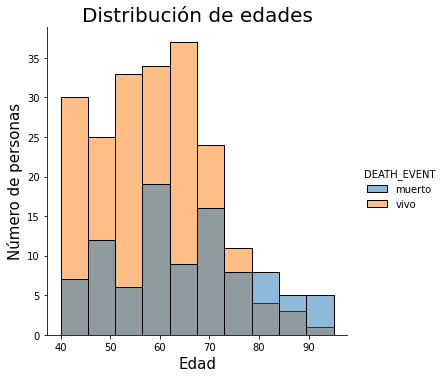

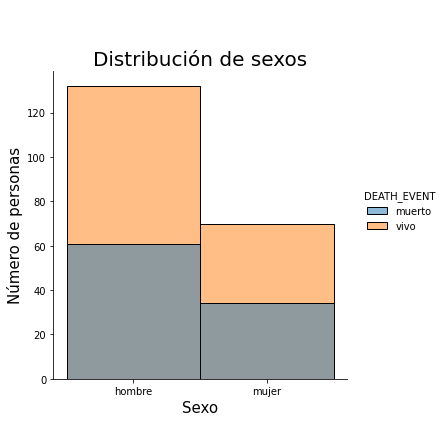

In [ ]:
# Visualizamos la distribución de las edades para ver si hay diferencia entre las personas que fallecieron y las que no
sns.displot(df, x = 'age', hue ='DEATH_EVENT')
plt.xlabel('Edad', fontsize = 15)
plt.ylabel('Número de personas', fontsize = 15)
plt.title('Distribución de edades', fontsize = 20)
plt.show()

# Distribución de sexos
sns.displot(df, x = 'sex', hue = 'DEATH_EVENT')
plt.xlabel('Sexo', fontsize = 15)
plt.ylabel('Número de personas', fontsize = 15)
plt.title('\n\nDistribución de sexos', fontsize = 20)
plt.show()


### 3-¿Cuáles son los factores que presentan una relacion fuerte con la propensión a la muerte?

In [ ]:
# Para poder realizar esto de una manera óptima y más entendible en cuanto al

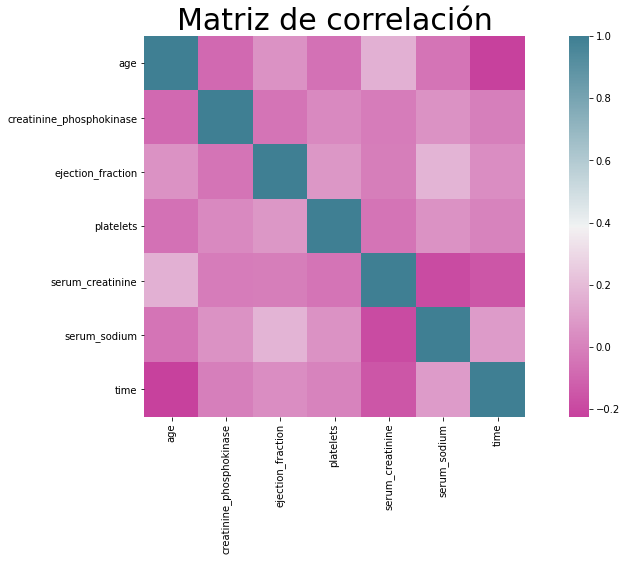

In [ ]:
# Visualizamos una matriz de correlación para obtener la información
plt.rcParams['figure.figsize'] = (16,7)
sns.heatmap(df.corr(), cmap=sns.diverging_palette(-30, -500, as_cmap=True), square=True)
plt.title('Matriz de correlación', fontsize = 30)
plt.show()

###4-¿Cuál es el perfil de los pacientes más propensos a sobrevivir?

In [ ]:
muertos = pd.get_dummies(df.DEATH_EVENT)
anemia = pd.get_dummies(df.anaemia)
diabetes = pd.get_dummies(df.diabetes)
presion = pd.get_dummies(df.high_blood_pressure)
sex = pd.get_dummies(df.sex)
fumar = pd.get_dummies(df.smoking)

df = pd.concat([muertos, anemia, diabetes, presion, sex, fumar, df], axis = 1)

df.drop(['anaemia','diabetes','high_blood_pressure','sex','smoking'], inplace = True, axis = 1)
df.head()

,muerto,vivo,anemico,no_anemico,diabetico,no_diabetico,hipertenso,no_hipertenso,hombre,mujer,fumador,no_fumador,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,DEATH_EVENT
0,1,0,0,1,0,1,1,0,1,0,0,1,75,582,20,265000.00,1.9,130,4,muerto
1,1,0,0,1,0,1,0,1,1,0,0,1,55,7861,38,263358.03,1.1,136,6,muerto
2,1,0,0,1,0,1,0,1,1,0,1,0,65,146,20,162000.00,1.3,129,7,muerto
3,1,0,1,0,0,1,0,1,1,0,0,1,50,111,20,210000.00,1.9,137,7,muerto
4,1,0,1,0,1,0,0,1,0,1,0,1,65,160,20,327000.00,2.7,116,8,muerto


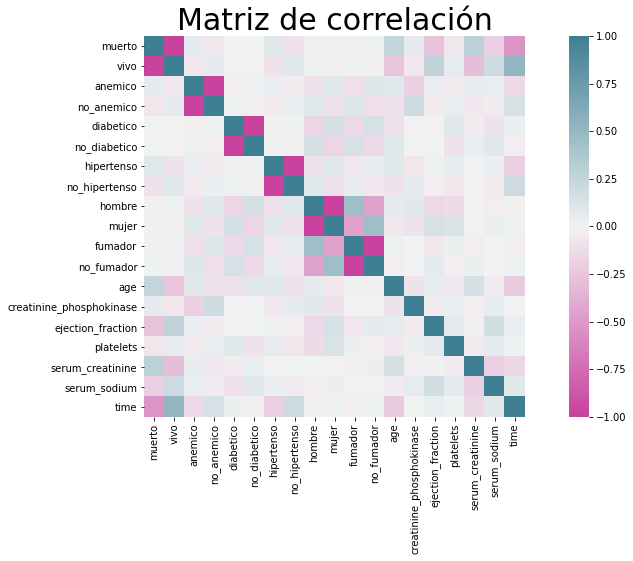

In [ ]:
# Visualizamos una matriz de correlación para obtener la información
plt.rcParams['figure.figsize'] = (16,7)
sns.heatmap(df.corr(), cmap=sns.diverging_palette(-30, -500, as_cmap=True), square=True)
plt.title('Matriz de correlación', fontsize = 30)
plt.show()

edad baja, no hipertenso, bombeas más sangre, alto sodio, y mas tiempo en la sala de cuidados

In [ ]:
df.drop(['muerto','vivo'], axis=1, inplace = True)

In [ ]:
df.head()

,anemico,no_anemico,diabetico,no_diabetico,hipertenso,no_hipertenso,hombre,mujer,fumador,no_fumador,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,DEATH_EVENT
0,0,1,0,1,1,0,1,0,0,1,75,582,20,265000.00,1.9,130,4,muerto
1,0,1,0,1,0,1,1,0,0,1,55,7861,38,263358.03,1.1,136,6,muerto
2,0,1,0,1,0,1,1,0,1,0,65,146,20,162000.00,1.3,129,7,muerto
3,1,0,0,1,0,1,1,0,0,1,50,111,20,210000.00,1.9,137,7,muerto
4,1,0,1,0,0,1,0,1,0,1,65,160,20,327000.00,2.7,116,8,muerto


In [ ]:
ks = KFold(n_splits=5)
cross = cross_val_score(LogisticRegression(), df.drop(['DEATH_EVENT'], axis = 1), df.DEATH_EVENT, cv = ks)
print(cross.mean()*100)

76.19774011299437


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(['DEATH_EVENT'], axis = 1), df.DEATH_EVENT, test_size= 0.2)

In [ ]:
logistic = LogisticRegressionCV(cv = 5)
logistic.fit(df.drop(['DEATH_EVENT'], axis = 1), df.DEATH_EVENT)
y_pred = logistic.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


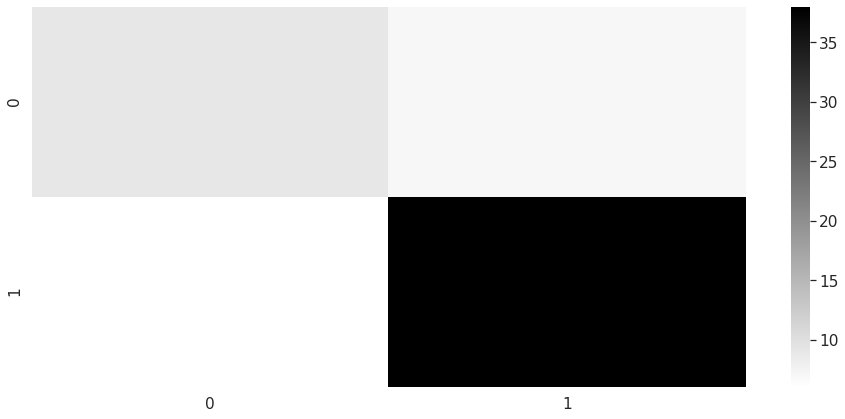

In [ ]:
sns.heatmap(confusion_matrix(Y_test, y_pred),  cmap = 'binary')